In [265]:





import datetime
import pytz
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta






In [266]:





# 30 min time frame
frameM30 = mt5.TIMEFRAME_M30

#1 min time frame
frameM1 = mt5.TIMEFRAME_M1

# 1 hour time frame
frameH1 = mt5.TIMEFRAME_H1





In [267]:





def getAssetList(assetSet = None):
    assetList = []
    if assetSet == 1:
        assetList = ['EURUSD', 'USDCHF']
    return assetList

        





In [268]:







## Defining the getQuotes method

def getQuotes(mt5TimeFrame, year = 2020, month = 1, day = 1, asset ='EURUSD'):
    
    ## Establishing the connection to MetaTrader 5
    if not mt5.initialize():
        print(f'MT5 initialization failed: Error code = {mt5.last_error}')
        quit()

    # Current time
    currentTime = datetime.datetime.now()

    # Defining the timezone and created utcFrom and utcTo dates
    timeZone = pytz.timezone('Asia/Kolkata')
    utcFrom = datetime.datetime(year, month, day, tzinfo = timeZone)
    utcTo = datetime.datetime(currentTime.year, currentTime.month, currentTime.day, tzinfo = timeZone)
    
    # Retrieving the data and returning it after converting it to pd dataframe
    return pd.DataFrame(mt5.copy_rates_range(asset, mt5TimeFrame, utcFrom, utcTo))







In [269]:



df = getQuotes(frameM30, 2023)
df





,time,open,high,low,close,tick_volume,spread,real_volume
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0
...,...,...,...,...,...,...,...,...
9835,1697232600,1.05078,1.05119,1.05047,1.05107,2348,9,0
9836,1697234400,1.05107,1.05137,1.05089,1.05108,2079,9,0
9837,1697236200,1.05108,1.05154,1.05103,1.05134,1835,9,0
9838,1697238000,1.05134,1.05135,1.05074,1.05081,782,9,0


In [270]:

lookBack = 800

def strategy(df):
    df['mah'] = ta.sma(close=df['high'], length=lookBack)
    df['mal'] = ta.sma(close=df['low'], length=lookBack)
    return df


In [271]:


df = strategy(df)

df



,time,open,high,low,close,tick_volume,spread,real_volume,mah,mal
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0,NaN,NaN
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0,NaN,NaN
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0,NaN,NaN
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0,NaN,NaN
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9835,1697232600,1.05078,1.05119,1.05047,1.05107,2348,9,0,1.056859,1.055931
9836,1697234400,1.05107,1.05137,1.05089,1.05108,2079,9,0,1.056843,1.055917
9837,1697236200,1.05108,1.05154,1.05103,1.05134,1835,9,0,1.056828,1.055901
9838,1697238000,1.05134,1.05135,1.05074,1.05081,782,9,0,1.056813,1.055885


In [272]:

buyIndices=[]
sellIndices=[]

buys=[]
sells=[]

position = None

sl = 0.5 / 100
slamount = None

for i in range(len(df)):
    # In order to check , if there is an existing upwards trend, we are doing the last check of i - 10
    if (i > 10) and (position is None) and (slamount is None) and (df.iloc[i]['low'] > df.iloc[i]['mal']) and (df.iloc[i]['low'] < df.iloc[i]['mah']) and (df.iloc[i - 1]['low'] > df.iloc[i]['mah']) and (df.iloc[i - 10]['low'] > df.iloc[i]['mah']):
        buyIndices.append(i)
        buys.append(df.iloc[i]['close'])
        position = 'long'
        slamount = df.iloc[i]['close'] - (sl * df.iloc[i]['close'])
    # In order to check, if there is an existing downwards trend, we are doing the last check of i - 10
    if (i > 10) and (position == 'long') and (slamount) and (
        (
            (df.iloc[i]['high'] < df.iloc[i]['mah']) and
            (df.iloc[i]['high'] > df.iloc[i]['mal']) and
            (df.iloc[i - 1]['high'] < df.iloc[i]['mal']) and
            (df.iloc[i - 10]['high'] < df.iloc[i - 10]['mal'])
        ) or (
            df.iloc[i]['close'] <= slamount
        )
    ):
        sellIndices.append(i)
        sells.append(df.iloc[i]['close'])
        position = None
        slamount = None





In [273]:

print(buys)
print(sells)

print(buyIndices)
print(sellIndices)


[1.08257, 1.06523, 1.06328, 1.0985, 1.07479, 1.08967, 1.0614]
[1.07658, 1.0585, 1.09762, 1.0996299999999999, 1.10694, 1.08382, 1.05492]
[1037, 2236, 2619, 4149, 5511, 8324, 9727]
[1223, 2243, 4134, 4386, 7074, 8341, 9777]


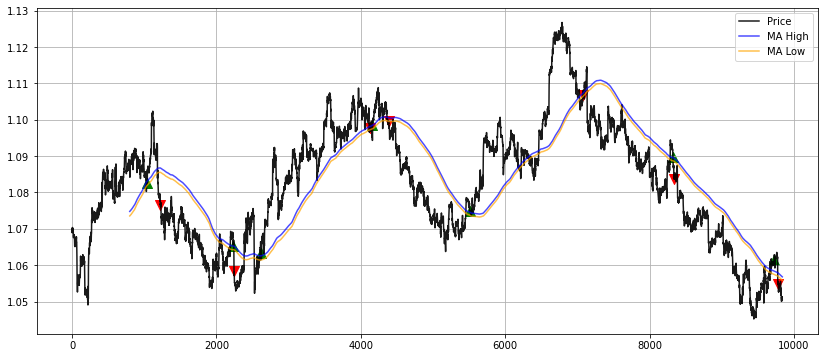

In [274]:


plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Price', color='black', alpha=0.9)
plt.plot(df['mah'], label='MA High', color='blue', alpha=0.7)
plt.plot(df['mal'], label='MA Low', color='orange', alpha=0.7)
plt.scatter(df.iloc[buyIndices].index, df.iloc[buyIndices]['close'], marker = '^', color = 'g', s = 100)
plt.scatter(df.iloc[sellIndices].index, df.iloc[sellIndices]['close'], marker = 'v', color = 'r', s = 100)
plt.legend()
plt.grid(True)
plt.show()



In [275]:


brokerage = 1 / 100

wins = 0
losses = 0

profit = 0
loss = 0

averageprofit = 0
averageloss = 0

netresult = ''

for i in range(len(sells)):
    maximum = max(sells[i], buys[i])
    brokerageAmount = brokerage * maximum
    diff = sells[i] - buys[i] - brokerageAmount
    if (diff > 0):
        wins += 1
        profit += diff
    if (diff < 0):
        losses += 1
        loss += abs(diff)

if (profit > loss):
    netresult = 'Win'
elif (profit == loss):
    netresult = 'None'
else:
    netresult = 'Loss'

averageprofit = profit / wins
averageloss = loss / losses
hitratio = (wins / (wins + losses)) * 100
profitfactor = (profit / loss)
expectancy = (averageprofit * hitratio) - (averageloss * (1 - hitratio))
riskreward = (averageprofit / averageloss)

print(f'''
    Net result = {netresult}
    Hit ratio = {hitratio} %
    Profit factor = {profitfactor} {{currency}}
    Expectancy = {expectancy} {{currency}}
    Realised risk reward ratio = {riskreward} {{currency}}
''')







    Net result = Loss
    Hit ratio = 28.57142857142857 %
    Profit factor = 0.5704948334510022 {currency}
    Expectancy = 1.0645104285714293 {currency}
    Realised risk reward ratio = 1.4262370836275056 {currency}

